#### Ridgeplot of trends in the full distributions for each latitude band
Ming Ge Jan 2025

In [6]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [13]:
def ridgeplot_vmax(df, col_label, col_data):
        #plt.figure(figsize=(10, 6)) 
        sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

        # we generate a color palette with Seaborn.color_palette()
        pal = sns.color_palette(palette='coolwarm', n_colors=4)

        # in the sns.FacetGrid class, the 'hue' represents colors with 'palette'
        g = sns.FacetGrid(df, row=col_label, hue = col_label, aspect=6, height=0.95, palette=pal)

        # then we add the densities kdeplots for each month
        g.map(sns.kdeplot, col_data,
              bw_adjust=1, clip_on=False,
              fill=True, alpha=0.8, linewidth=1.5)

        # here we add a horizontal line for each plot
        g.map(plt.axhline, y=0, lw=2, clip_on=False)
         
        # Loop over the FacetGrid figure axes (g.axes.flat) and add the time period as text with the right color
        # notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
        for i, ax in enumerate(g.axes.flat):
            ax.text(-15, 0.02, df.time.unique()[i],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color()),
            ax.set_ylabel('')

        # we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
        g.fig.subplots_adjust(hspace=-0.3)

        # eventually we remove axes titles, yticks and spines
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)

        plt.setp(ax.get_xticklabels(), fontsize=15)
        plt.xlabel('Vmax', fontsize=12)
        g.fig.suptitle( 'Vmax distribution at latitude:' + str(bin_center),
               ha='center', fontsize=15, fontweight='bold')
        plt.show();


In [8]:
def rd_allVmax_HR_SH(dir_hr, year_s, year_e, extent):
    '''
    get and return Vmax of ensembel Vmax of that extent(region) between year_s and year_e
    '''
    lon_s = extent[0]
    lon_e = extent[1]
    lat_s = extent[2]
    lat_e = extent[3]

    dirs = [ff for ff in glob.glob(dir_hr + "*")]
    n_mem = len(dirs)

    vmax_1d = []
     
    for dir in dirs:
        for year in range(year_s, year_e + 1):
            name = dir[len(dir_hr) + 8:-4]
            flnm = dir + '/' + 'CESM_HR_TC_'+ name+'_output_' + str(year) + '_SH.txt'            
            df = pd.read_csv(flnm, delimiter=', ', engine='python')
             
            tc_ids = np.unique(df.track_id.astype(int))
            for tc_id in tc_ids:
                df_single = df.loc[df.track_id.astype(int) == tc_id]
                lat_1d = df_single.lat.values.astype(float)
                lon_1d = df_single.lon.values.astype(float)
                lon_1d = np.where(lon_1d < 0, lon_1d+360, lon_1d)
                spd_1d = df_single.wind10.values.astype(float) 
                
                latmask = np.where((lat_1d>=lat_s) & (lat_1d < lat_e))
                if(len(latmask[0]) != 0):
                    lat_latmask = lat_1d[latmask]
                    lon_latmask = lon_1d[latmask]
                    spd_latmask = spd_1d[latmask]

                    lonmask = np.where((lon_latmask>=lon_s) & (lon_latmask < lon_e))
                    if(len(lonmask[0]) !=0):
                        spd_final = spd_latmask[lonmask] 
                        vmax_1d.extend(spd_final)                                
    return vmax_1d           

In [9]:
dir_hr = '/glade/campaign/mmm/c3we/done/pcast/CESM_HR/'
dir_o  = '/glade/campaign/mmm/c3we/mingge/TC/DATA/'

# 4 time period
year_s = [1941, 1981, 2021, 2061]
year_e = [1980, 2020, 2060, 2100]

n_year = year_e[0] - year_s[0] + 1

n_p = len(year_s)

# 2 regions
lat_s_1d = [-41, -41]
lat_e_1d = [-9, -9]
lon_s_1d = [145, 100]
lon_e_1d = [160, 135] 

n_region = len(lat_s_1d) 

Region 1 145 160


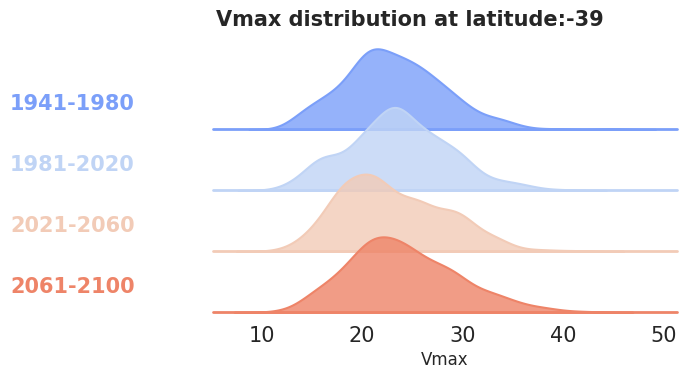

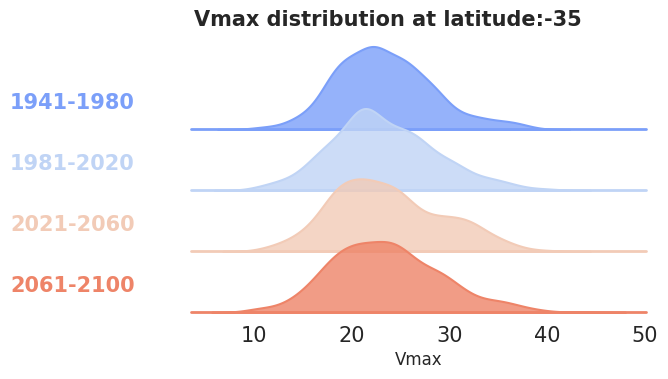

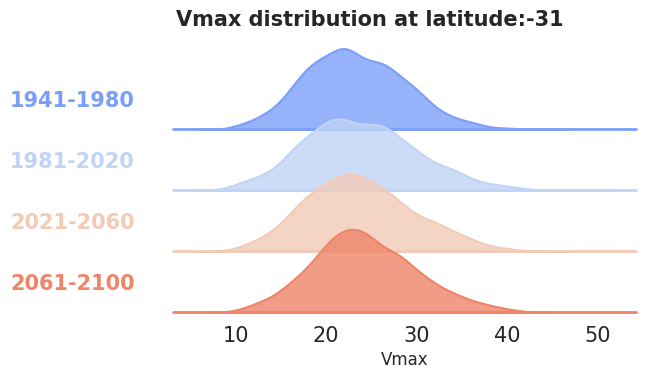

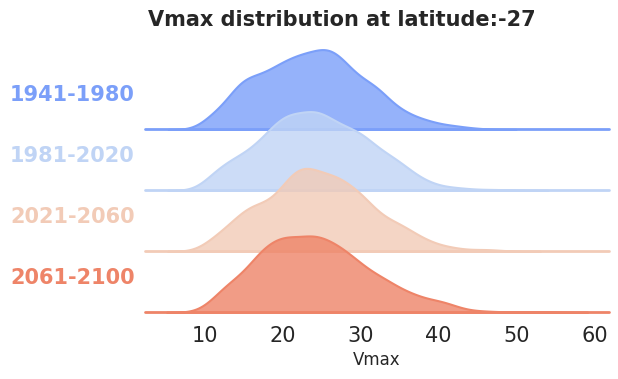

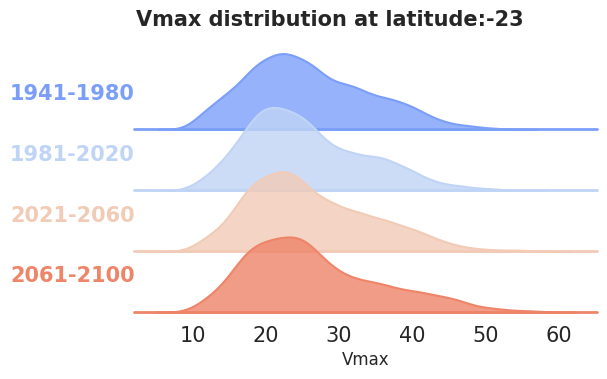

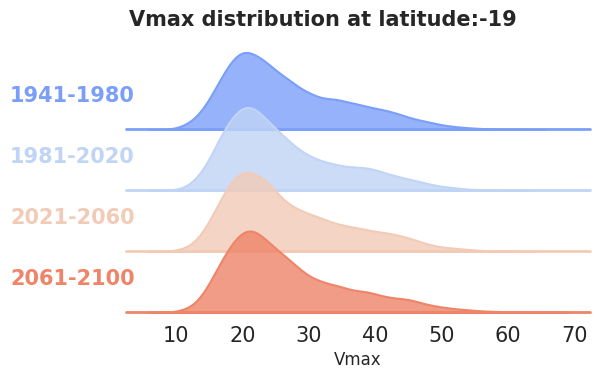

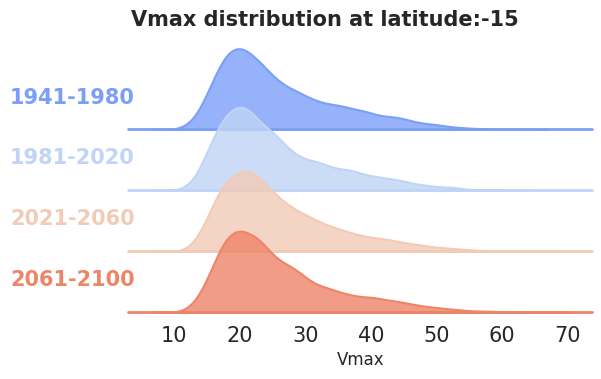

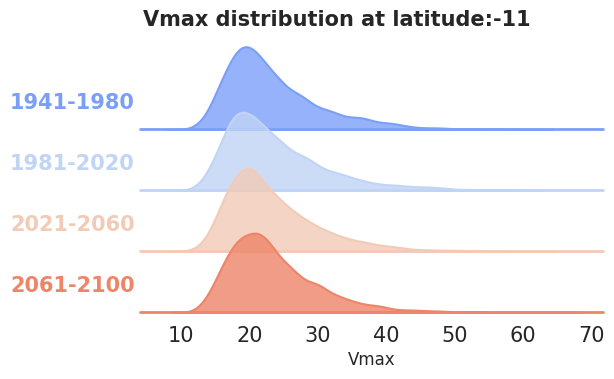

Region 2 100 135


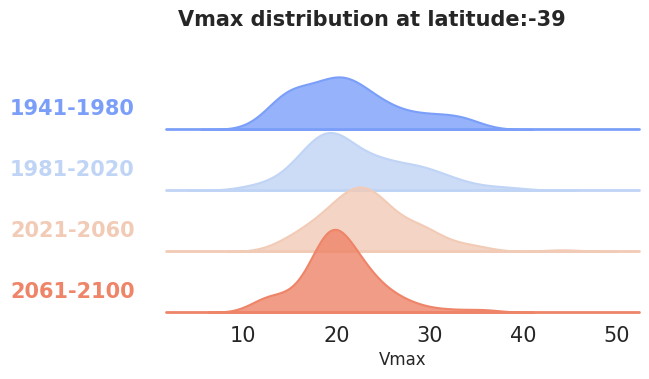

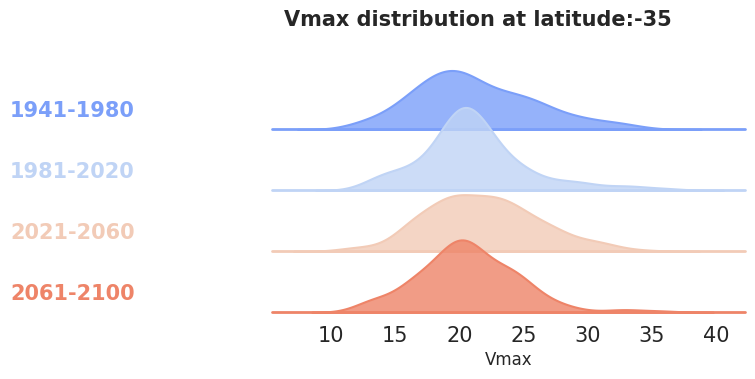

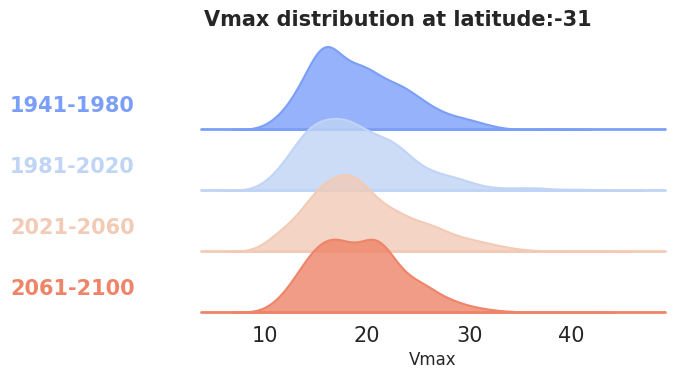

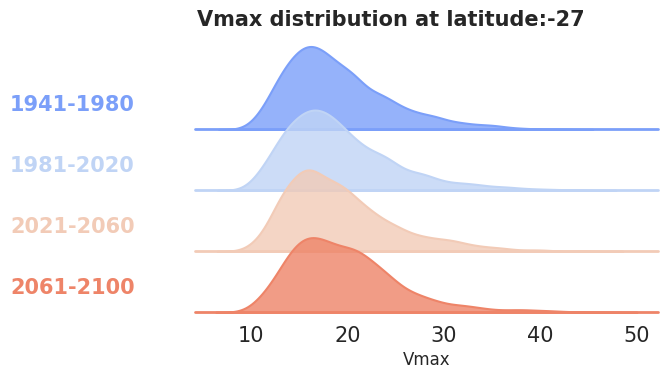

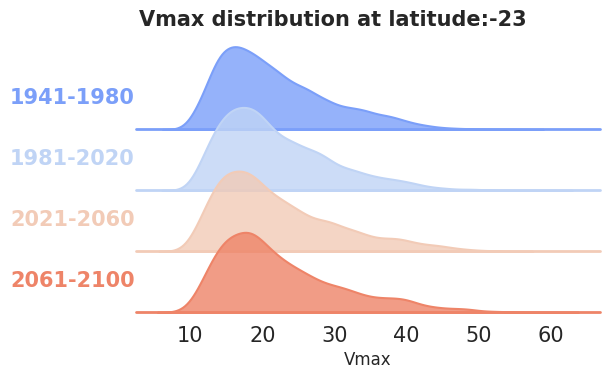

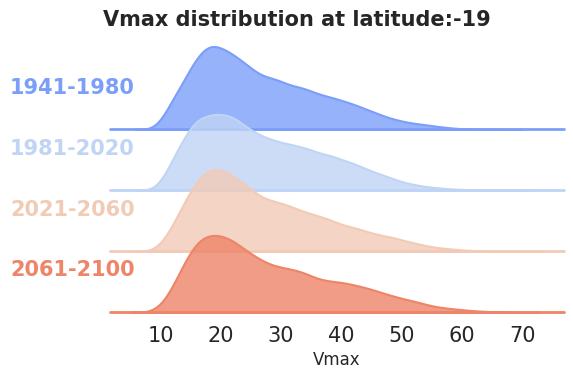

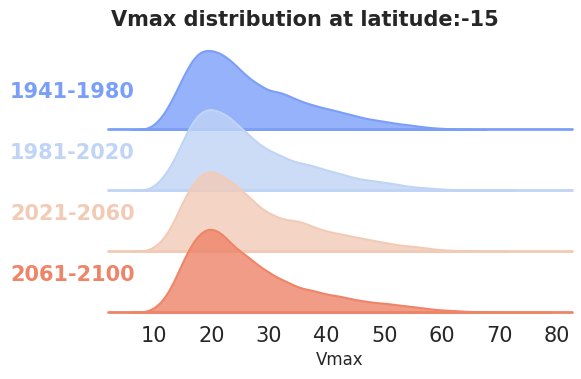

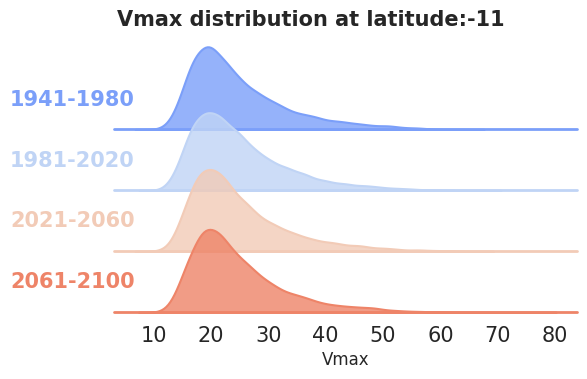

CPU times: user 9min 17s, sys: 3.09 s, total: 9min 20s
Wall time: 9min 48s


In [14]:
%%time

bin_width = 4
color_1d = ['yellow', 'orange', 'red', 'purple']
for nr in range(n_region): 
    lat_s = lat_s_1d[nr]
    lat_e = lat_e_1d[nr]
    lon_s = lon_s_1d[nr]
    lon_e = lon_e_1d[nr] 
    print('Region ' + str(nr + 1), lon_s, lon_e)
     
    # Define bins
    bins = np.arange(lat_s, lat_e+bin_width, bin_width)
    n_bins = len(bins) - 1

    for nb in range(n_bins):
        bin_center = int((bins[nb]+ bins[nb+1])/2)
        extent_bin = [lon_s, lon_e, bins[nb], bins[nb+1]]
        vmax_1d = [] 
        period_1d = []
        for nt in range(n_p): 
            time_s = str(year_s[nt]) + '-' + str(year_e[nt])
            vmax_tmp = rd_allVmax_HR_SH(dir_hr, year_s[nt], year_e[nt], extent_bin)
            period_tmp = [time_s] * (len(vmax_tmp))  
            vmax_1d.extend(vmax_tmp)
            period_1d.extend(period_tmp)
             
        data = {'vmax':vmax_1d, 'time': period_1d }
        df = pd.DataFrame(data)
        
        ridgeplot_vmax(df, 'time', 'vmax')
                 

In [ ]:
https://docs.bokeh.org/en/2.4.3/docs/gallery/ridgeplot.html